In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

In [2]:
df = pd.read_csv('cleaned_df_dropped_fts.csv')
df.head()

,host_is_superhost,no_of_host_verifications,host_response_time,number_of_reviews,amenities_count,calculated_host_listings_count,reviews_per_month,price,security_deposit,cleaning_fee,...,price_per_person,days_since_calendar_updated,account_duration_days,space_char_count,neighborhood_overview_char_count,notes_char_count,host_about_char_count,space_char_count_grouped,neighborhood_overview_char_count_grouped,notes_char_count_grouped
0,0,4,2,207,10,2,4.07,85.0,0.0,0.0,...,21.250000,28,1607,1000,0,0,372,20,1,1
1,1,6,1,43,16,6,1.48,150.0,100.0,40.0,...,37.500000,0,1047,1000,167,1000,74,20,4,20
2,0,5,2,20,21,2,1.15,975.0,1000.0,300.0,...,88.636364,35,571,1000,669,155,343,20,14,4
3,0,5,1,38,13,1,0.89,450.0,700.0,125.0,...,75.000000,49,1497,488,492,9,354,10,10,1
4,1,4,1,58,7,1,2.46,80.0,150.0,0.0,...,40.000000,35,1314,1000,95,82,229,20,2,2


In [3]:
predictor_df = df.drop(['host_is_superhost'], axis = 1)

In [5]:
print("Data dims : ", predictor_df.shape)

Data dims :  (2803, 22)


In [4]:
superhost_df = df['host_is_superhost']

In [7]:
superhost_df.shape

(2803,)

In [22]:
superhost_df.value_counts(normalize = True)

0    0.743489
1    0.256511
Name: host_is_superhost, dtype: float64

Before beginning to check the models, a benchmark for a dummy classifier which simply predicts 1 class for all values could be obtained, so in this case the rate to aim above for should be 0.743489

## Multi-Variate Decision Tree

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

In [8]:
X_train, X_test, y_train, y_test = train_test_split(predictor_df, superhost_df, test_size = 0.2)

In [9]:
dectree = DecisionTreeClassifier(class_weight='balanced')  # create the decision tree object

Using cross-validation score to check model effectiveness and hopefully avoid removing important points from the train set

In [10]:
from sklearn.model_selection import cross_val_score

Split the data into 5 equal parts, using 1 part as a test set and the other 4 as a train set; and change the test set with each iteration

In [11]:
cross_val_score(dectree, predictor_df, superhost_df, cv=5)


array([0.7201426 , 0.73083779, 0.73796791, 0.73571429, 0.69285714])

Using LeaveOneOut, which leaves only 1 point as a test set and the remaining data points are used as test sets.

In [12]:
from sklearn.model_selection import LeaveOneOut

In [13]:
scores = cross_val_score(dectree, predictor_df, superhost_df, cv=LeaveOneOut())
scores.mean()

0.7263646093471281

The above shows the overall accuracy rate of each of the predictions of the single point that is used as a test set. But this takes way too long so it will be not be used again later

Using a validation curve to find the optimal value for the hyperparameter max_depth in this case for dectree

In [14]:
from sklearn.model_selection import validation_curve

Text(0, 0.5, 'score')

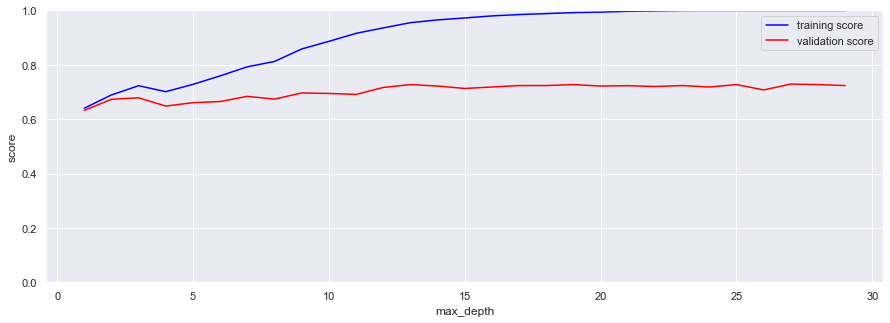

In [15]:

train_scores, test_scores = validation_curve(dectree, 
                                             predictor_df, 
                                             superhost_df, 
                                             param_name="max_depth", 
                                             param_range=np.arange(1, 30),
                                             cv=5, 
                                             scoring="accuracy"
                                             )
f, axes = plt.subplots(1, 1, figsize=(15, 5))
plt.plot(np.arange(1, 30), np.median(train_scores, 1), color='blue', label='training score')
plt.plot(np.arange(1, 30), np.median(test_scores, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('max_depth')
plt.ylabel('score')

In [19]:
np.median(test_scores, 1)[26]

0.7290552584670231

In [16]:
np.argmax(np.median(test_scores, 1))

26

Score is highest at index = 26, i.e. max_depth = 27

Using GridSearch to check optimal max_depth

In [20]:
from sklearn.model_selection import GridSearchCV

In [21]:
param_grid = {'max_depth': np.arange(1, 30)}

In [22]:
grid = GridSearchCV(dectree, param_grid, cv=5)

In [25]:
grid.fit(predictor_df, superhost_df)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'

In [26]:
grid.best_params_

{'max_depth': 27}

Modify the decision tree with the given results

In [27]:
dectree = DecisionTreeClassifier(max_depth = 27, class_weight='balanced')  # create the decision tree object

In [28]:
dectree.fit(X_train, y_train)  # train the decision tree model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=27, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [29]:
y_train_pred1 = dectree.predict(X_train)
y_test_pred1 = dectree.predict(X_test)

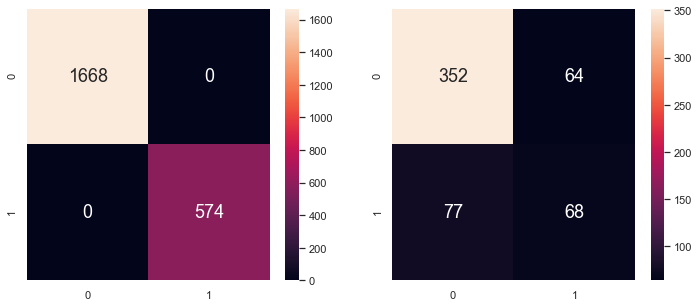

In [30]:
# Plot the Confusion Matrix
f, axes = plt.subplots(1, 2, figsize=(12, 5))
sb.heatmap(confusion_matrix(y_train, y_train_pred1), annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred1), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])


In [31]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X_test, y_test))
print()



Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 1.0

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7486631016042781



In [32]:
from sklearn.metrics import classification_report

In [33]:
print(classification_report(y_test, y_test_pred1))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       416
           1       0.52      0.47      0.49       145

    accuracy                           0.75       561
   macro avg       0.67      0.66      0.66       561
weighted avg       0.74      0.75      0.74       561



In [34]:
TN_Test, FP_Test, FN_Test, TP_Test = confusion_matrix(y_test, y_test_pred1).ravel()

print(TN_Test, FP_Test, FN_Test, TP_Test)
print()

print("FPR for Test Set =", FP_Test/(FP_Test+TN_Test))

print("FNR for Test Set =", FN_Test/(FN_Test+TP_Test))

352 64 77 68

FPR for Test Set = 0.15384615384615385
FNR for Test Set = 0.5310344827586206


Decision tree is probably not be the optimal model for this dataset

# Random Forest Classification

In [5]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
forest = RandomForestClassifier(class_weight='balanced')

Like above, objective is to find the optimal hyperparameters first before fitting the model

In [36]:
cross_val_score(forest, predictor_df, superhost_df, cv=5)

array([0.78074866, 0.78431373, 0.79857398, 0.7625    , 0.77142857])

Text(0, 0.5, 'score')

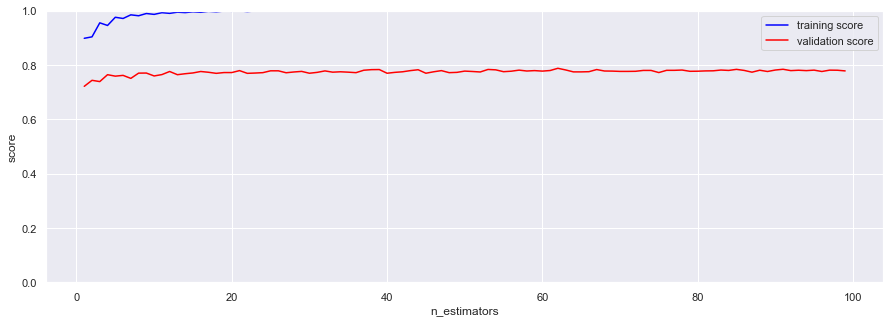

In [72]:
f_train_scores1, f_test_scores1 = validation_curve(forest, 
                                             predictor_df, 
                                             superhost_df, 
                                             param_name="n_estimators", 
                                             param_range=np.arange(1, 100),
                                             n_jobs = -1,
                                            cv=5,
                                             scoring="accuracy"
                                             )
f, axes = plt.subplots(1, 1, figsize=(15, 5))
plt.plot(np.arange(1, 100), np.mean(f_train_scores1, 1), color='blue', label='training score')
plt.plot(np.arange(1, 100), np.mean(f_test_scores1, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('n_estimators')
plt.ylabel('score')

In [77]:
np.mean(f_test_scores1, 1)[61]

0.7873644003055768

In [73]:
np.argmax(np.mean(f_test_scores1, 1))

61

Text(0, 0.5, 'score')

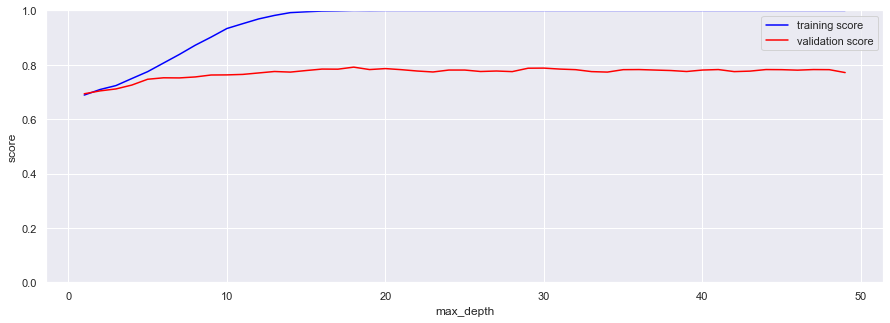

In [49]:
f_train_scores, f_test_scores = validation_curve(forest, 
                                             predictor_df, 
                                             superhost_df, 
                                             param_name="max_depth", 
                                             param_range=np.arange(1, 50),
                                             scoring="accuracy",
                                            cv=5,
                                            n_jobs = -1
                                             )
f, axes = plt.subplots(1, 1, figsize=(15, 5))
plt.plot(np.arange(1, 50), np.median(f_train_scores, 1), color='blue', label='training score')
plt.plot(np.arange(1, 50), np.median(f_test_scores, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('max_depth')
plt.ylabel('score')

In [51]:
np.median(f_test_scores, 1)[17]

0.7914438502673797

In [50]:
np.argmax(np.median(f_test_scores, 1))

17

18 may be the optimal max_depth

For random forest, instead of only using Grid Search, which tries out every combination, I'll use randomized search as well

In [86]:
from sklearn.model_selection import RandomizedSearchCV

In [93]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3]

In [94]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [95]:
# Use the random grid to search for best hyperparameters
rf_random = RandomizedSearchCV(estimator = forest, param_distributions = random_grid, n_iter = 30, cv = 5, n_jobs = -1)
# Fit the random search model
rf_random.fit(predictor_df, superhost_df)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight='balanced',
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
         

In [96]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 30}

After narrowing down, use Grid Search for the remaining permutations:

In [153]:
f_param_grid = {'n_estimators': [100,200,300,500,1000],
               'max_depth': [20,30,50],
            'max_features': ['auto',0.1,0.5]}

In [154]:
f_grid = GridSearchCV(forest, f_param_grid, cv=5, n_jobs = -1)

In [155]:
f_grid.fit(predictor_df, superhost_df)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=20,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=5,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=1000, n_jobs=None,
                                              oob_score=False,
                                              

Result of a previous grid search:

In [100]:
f_grid.best_params_

{'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 1000}

Create the new model

In [188]:
forest = RandomForestClassifier(max_depth = 20, min_samples_split= 5, n_estimators=1000, class_weight='balanced')

In [189]:
forest.fit(X_train, y_train) # train the model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [190]:
y_train_pred2 = forest.predict(X_train)
y_test_pred2 = forest.predict(X_test)

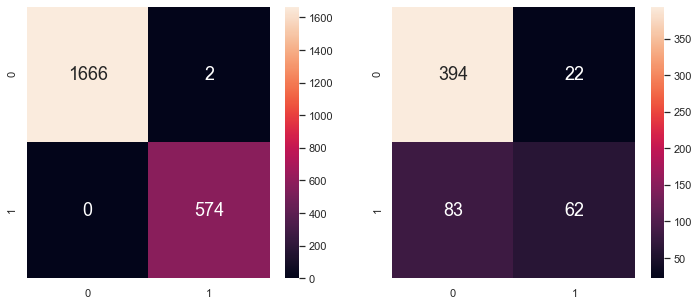

In [191]:
# Plot the Confusion Matrix
f, axes = plt.subplots(1, 2, figsize=(12, 5))
sb.heatmap(confusion_matrix(y_train, y_train_pred2), annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred2), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

In [192]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", forest.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", forest.score(X_test, y_test))
print()

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9991079393398751

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.8128342245989305



In [193]:
TN_Test, FP_Test, FN_Test, TP_Test = confusion_matrix(y_train, y_train_pred2).ravel()

print(TN_Test, FP_Test, FN_Test, TP_Test)
print()

print("FPR =", FP_Test/(FP_Test+TN_Test))

print("FNR =", FN_Test/(FN_Test+TP_Test))

1666 2 0 574

FPR = 0.001199040767386091
FNR = 0.0


In [194]:
TN_2, FP_2, FN_2, TP_2 = confusion_matrix(y_test, y_test_pred2).ravel()

print(TN_2, FP_2, FN_2, TP_2)
print()

print("FPR =", FP_2/(FP_2+TN_2))

print("FNR =", FN_2/(FN_2+TP_2))

394 22 83 62

FPR = 0.052884615384615384
FNR = 0.5724137931034483


Better score but more than half of the superhosts are predicted wrongly

# Support Vector Machine

Creates a multidimensional plane to separate the classes

In [195]:
from sklearn.svm import SVC
from sklearn.svm import NuSVC

In [223]:
svc = NuSVC(gamma='scale', class_weight='balanced')

In [224]:
svc.fit(X_train, y_train) # train the model

NuSVC(break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.5, probability=False, random_state=None, shrinking=True,
      tol=0.001, verbose=False)

In [225]:
y_train_pred3 = svc.predict(X_train)
y_test_pred3 = svc.predict(X_test)

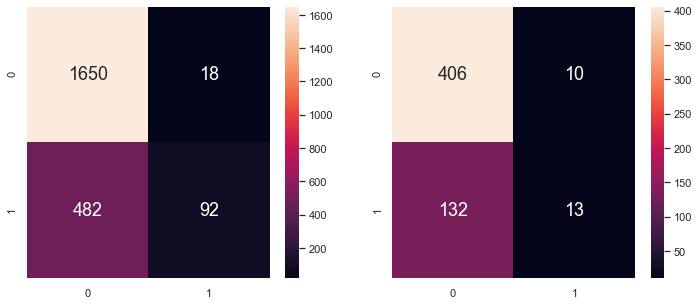

In [226]:
# Plot the Confusion Matrix
f, axes = plt.subplots(1, 2, figsize=(12, 5))
sb.heatmap(confusion_matrix(y_train, y_train_pred3), annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred3), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

In [227]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", svc.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", svc.score(X_test, y_test))
print()

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.7769848349687779

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7468805704099821



## BalancedRandomForestClassifier

For imbalanced sets, supposedly

In [196]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [198]:
bforest = BalancedRandomForestClassifier(max_depth = 20, min_samples_split= 5, n_estimators=1000)

In [199]:
bforest.fit(X_train, y_train) # train the model

BalancedRandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                               criterion='gini', max_depth=20,
                               max_features='auto', max_leaf_nodes=None,
                               max_samples=None, min_impurity_decrease=0.0,
                               min_samples_leaf=2, min_samples_split=5,
                               min_weight_fraction_leaf=0.0, n_estimators=1000,
                               n_jobs=None, oob_score=False, random_state=None,
                               replacement=False, sampling_strategy='auto',
                               verbose=0, warm_start=False)

In [200]:
y_train_pred5 = bforest.predict(X_train)
y_test_pred5 = bforest.predict(X_test)

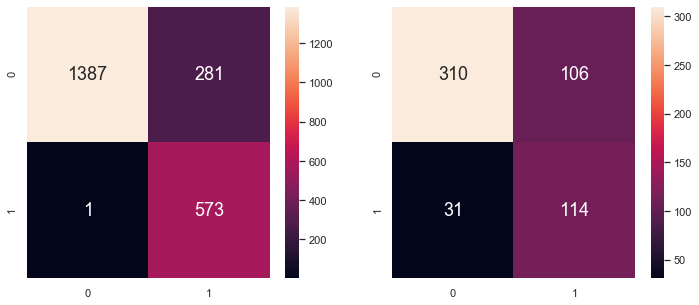

In [202]:
# Plot the Confusion Matrix
f, axes = plt.subplots(1, 2, figsize=(12, 5))
sb.heatmap(confusion_matrix(y_train, y_train_pred5), annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred5), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

In [204]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", bforest.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", bforest.score(X_test, y_test))
print()

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.8742194469223907

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.7557932263814616



Predicts superhosts more accurately

Logistic Regression; uses a logistic function to model the probabilities for binary classification

In [212]:
from sklearn.linear_model import LogisticRegression

In [218]:
log = LogisticRegression(class_weight = 'balanced',solver='liblinear')

In [219]:
log.fit(X_train, y_train) # train the model

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [220]:
y_train_pred6 = log.predict(X_train)
y_test_pred6 = log.predict(X_test)

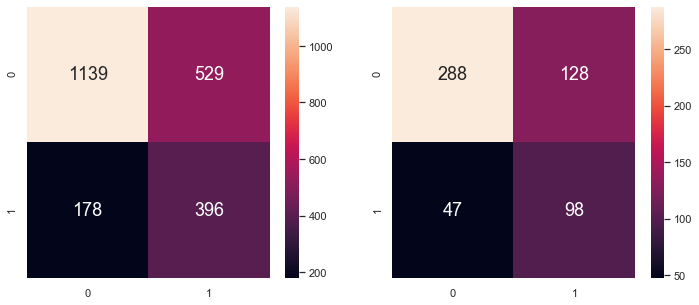

In [221]:
# Plot the Confusion Matrix
f, axes = plt.subplots(1, 2, figsize=(12, 5))
sb.heatmap(confusion_matrix(y_train, y_train_pred6), annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(confusion_matrix(y_test, y_test_pred6), 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

In [222]:
# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", log.score(X_train, y_train))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", log.score(X_test, y_test))
print()

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.6846565566458519

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.6880570409982175



### Extracting Test Set

In [228]:
test_df = pd.read_csv('cleaned_df_2020.csv')
test_df.shape

(5249, 23)

In [229]:
test_df.head()

,host_is_superhost,no_of_host_verifications,host_response_time,number_of_reviews,amenities_count,calculated_host_listings_count,reviews_per_month,price,security_deposit,cleaning_fee,...,price_per_person,days_since_calendar_updated,account_duration_days,space_char_count,neighborhood_overview_char_count,notes_char_count,host_about_char_count,space_char_count_grouped,neighborhood_overview_char_count_grouped,notes_char_count_grouped
0,1,8,1,32,39,2,0.23,296.0,500.0,250.0,...,32.888889,21,4221,1000,404,200,59,20,9,4
1,0,5,3,150,21,3,1.15,90.0,200.0,40.0,...,45.000000,92,3979,999,180,382,192,20,4,8
2,1,6,2,148,34,8,1.26,62.0,100.0,20.0,...,31.000000,15,3844,1000,669,205,2633,20,14,5
3,1,7,1,466,48,4,3.63,79.0,0.0,45.0,...,39.500000,5,3814,1000,308,1000,281,20,7,20
4,1,4,2,40,50,2,0.40,165.0,300.0,120.0,...,41.250000,2,3870,1000,248,193,805,20,5,4


In [230]:
predictor_df_test = test_df.drop(['host_is_superhost'], axis = 1)

In [231]:
print("Data dims : ", predictor_df_test.shape)

Data dims :  (5249, 22)


In [232]:
superhost_df_test = test_df['host_is_superhost']

In [233]:
print("Data dims : ", superhost_df_test.shape)

Data dims :  (5249,)


In [234]:
test_prediction_1 = dectree.predict(predictor_df_test)

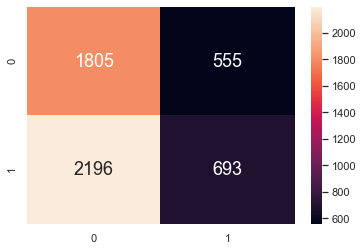

In [235]:
sb.heatmap(confusion_matrix(superhost_df_test, test_prediction_1), annot = True, fmt=".0f", annot_kws={"size": 18})


In [236]:
# Check the Goodness of Fit
print("Classification Accuracy \t:", dectree.score(predictor_df_test, superhost_df_test))
print()

TN_Test1, FP_Test1, FN_Test1, TP_Test1 = confusion_matrix(superhost_df_test, test_prediction_1).ravel()

print(TN_Test1, FP_Test1, FN_Test1, TP_Test1)
print()

print("FPR =", FP_Test1/(FP_Test1+TN_Test1))

print("FNR =", FN_Test1/(FN_Test1+TP_Test1))

Classification Accuracy 	: 0.4759001714612307

1805 555 2196 693

FPR = 0.23516949152542374
FNR = 0.7601246105919003


In [237]:
test_prediction_2 = forest.predict(predictor_df_test)

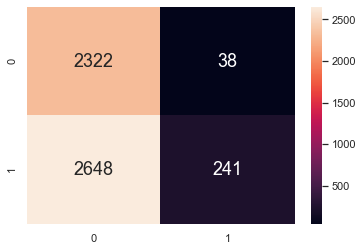

In [238]:
sb.heatmap(confusion_matrix(superhost_df_test, test_prediction_2), annot = True, fmt=".0f", annot_kws={"size": 18})


In [240]:
# Check the Goodness of Fit
print("Classification Accuracy \t:", forest.score(predictor_df_test, superhost_df_test))
print()

TN_Test2, FP_Test2, FN_Test2, TP_Test2 = confusion_matrix(superhost_df_test, test_prediction_2).ravel()

print(TN_Test2, FP_Test2, FN_Test2, TP_Test2)
print()

print("FPR =", FP_Test2/(FP_Test2+TN_Test2))

print("FNR =", FN_Test2/(FN_Test2+TP_Test2))

Classification Accuracy 	: 0.4882834825681082

2322 38 2648 241

FPR = 0.016101694915254237
FNR = 0.9165801315334026


In [242]:
test_prediction_3 = svc.predict(predictor_df_test)

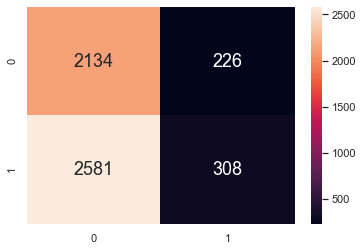

In [243]:
sb.heatmap(confusion_matrix(superhost_df_test, test_prediction_3), annot = True, fmt=".0f", annot_kws={"size": 18})

In [245]:
# Check the Goodness of Fit
print("Classification Accuracy \t:", svc.score(predictor_df_test, superhost_df_test))
print()

TN_Test3, FP_Test3, FN_Test3, TP_Test3 = confusion_matrix(superhost_df_test, test_prediction_3).ravel()

print(TN_Test3, FP_Test3, FN_Test3, TP_Test3)
print()

print("FPR =", FP_Test3/(FP_Test3+TN_Test3))

print("FNR =", FN_Test3/(FN_Test3+TP_Test3))

Classification Accuracy 	: 0.4652314726614593

2134 226 2581 308

FPR = 0.09576271186440678
FNR = 0.8933887158186223


In [246]:
test_prediction_4 = bforest.predict(predictor_df_test)

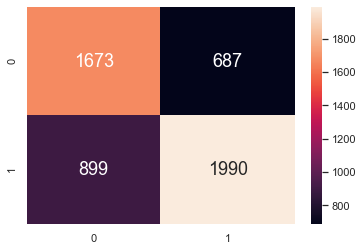

In [247]:
sb.heatmap(confusion_matrix(superhost_df_test, test_prediction_4), annot = True, fmt=".0f", annot_kws={"size": 18})

In [249]:
# Check the Goodness of Fit
print("Classification Accuracy \t:", bforest.score(predictor_df_test, superhost_df_test))
print()

TN_Test4, FP_Test4, FN_Test4, TP_Test4 = confusion_matrix(superhost_df_test, test_prediction_4).ravel()

print(TN_Test4, FP_Test4, FN_Test4, TP_Test4)
print()

print("FPR =", FP_Test4/(FP_Test4+TN_Test4))

print("FNR =", FN_Test4/(FN_Test4+TP_Test4))

Classification Accuracy 	: 0.697847208992189

1673 687 899 1990

FPR = 0.2911016949152542
FNR = 0.31118033921772237


In [250]:
test_prediction_5 = log.predict(predictor_df_test)

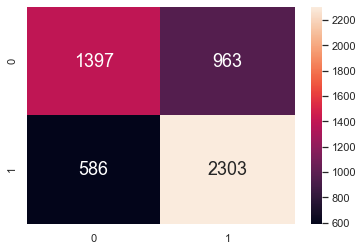

In [251]:
sb.heatmap(confusion_matrix(superhost_df_test, test_prediction_5), annot = True, fmt=".0f", annot_kws={"size": 18})

In [252]:
# Check the Goodness of Fit
print("Classification Accuracy \t:", log.score(predictor_df_test, superhost_df_test))
print()

TN_Test3, FP_Test3, FN_Test3, TP_Test3 = confusion_matrix(superhost_df_test, test_prediction_5).ravel()

print(TN_Test3, FP_Test3, FN_Test3, TP_Test3)
print()

print("FPR =", FP_Test3/(FP_Test3+TN_Test3))

print("FNR =", FN_Test3/(FN_Test3+TP_Test3))

Classification Accuracy 	: 0.7048961706991808

1397 963 586 2303

FPR = 0.4080508474576271
FNR = 0.20283835237106265


The models that predicted a greater % of superhosts accurately previously, scored higher with this unseen test set, which had a greater proportion of superhosts than nonsuperhosts, whereas for the training set it was the other way round. Thus, I will attempt to oversample the superhosts in the training set before fitting the model, via SMOTE to see if this can help improve scores on the test set, using similar models as the ones here